In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os

C:\Users\Orest\anaconda3\lib\site-packages\sklearn\utils\multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


In [2]:
train_df = pd.read_csv('fashion-mnist_train.csv',sep=',')
test_df = pd.read_csv('fashion-mnist_test.csv', sep = ',')

In [3]:
train_data= np.array(train_df, dtype= 'float32')
test_data= np.array(test_df, dtype= 'float32')

In [4]:
x_train = train_data[:,1:]/255
y_train = train_data[:,0]

x_test= test_data[:,1:]/255
y_test=test_data[:,0]

In [5]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 47)

In [6]:
class_names= ['Tshirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams['figure.constrained_layout.use'] = True

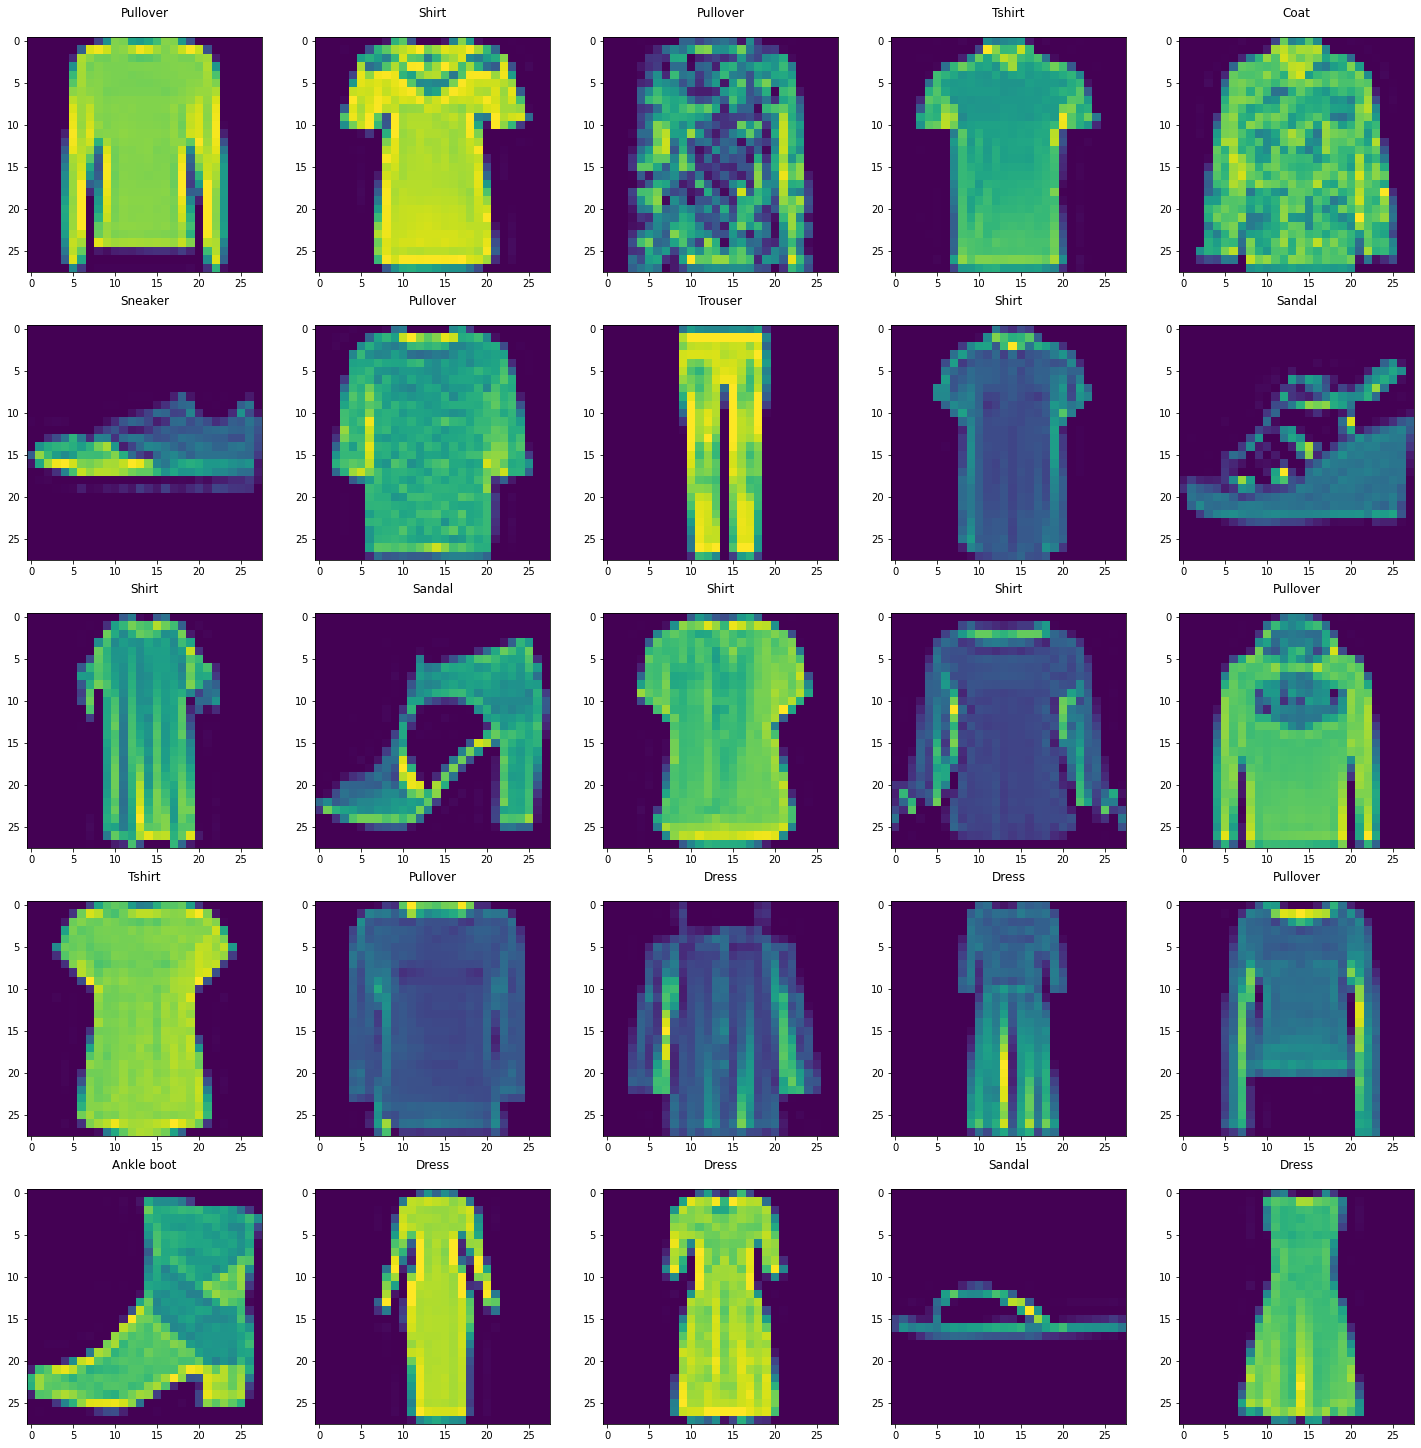

In [7]:
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.imshow(x_train[i].reshape((28,28)))
    label_index= int(y_train[i])
    plt.title(class_names[label_index], pad=20)
plt.show()

In [8]:
image_shape = (28,28,1) 
x_train= x_train.reshape(x_train.shape[0], *image_shape)
x_test = x_test.reshape(x_test.shape[0],*image_shape)
x_validate = x_validate.reshape(x_validate.shape[0],*image_shape)

In [9]:
train_groups = [x_train[np.where(y_train==i)[0]] for i in np.unique(y_train)]
test_groups = [x_test[np.where(y_test==i)[0]] for i in np.unique(y_train)]
print('train groups:', [x.shape[0] for x in train_groups])
print('test groups:', [x.shape[0] for x in test_groups])

train groups: [4776, 4806, 4781, 4814, 4804, 4788, 4817, 4781, 4831, 4802]
test groups: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPool2D, Activation, Flatten, Dense, Dropout

img_in = Input(shape=x_train.shape[1:], name='FeatureNet_ImageInput')
n_layer = img_in
n_layer = Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation= 'relu', input_shape= image_shape)(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(n_layer)
n_layer = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(n_layer)
n_layer = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same')(n_layer)
n_layer = BatchNormalization()(n_layer)
n_layer = MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(n_layer)
n_layer = Flatten()(n_layer)
n_layer = Dense(4096, activation='relu')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = Dense(4096, activation='relu')(n_layer)
n_layer = Dropout(0.5)(n_layer)
n_layer = Dense(10, activation='softmax')(n_layer)

feature_model = Model(inputs=[img_in], outputs=[n_layer], name='FeatureGenerationModel')
feature_model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 5, 96)          11712     
_________________________________________________________________
batch_normalization (BatchNo (None, 5, 5, 96)          384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 96)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 256)         614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 256)         1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 25

In [11]:
from keras.layers import concatenate
img_a_in = Input(shape=x_train.shape[1:], name='ImageA_Input')
img_b_in = Input(shape=x_train.shape[1:], name='ImageB_Input')
img_a_feat = feature_model(img_a_in)
img_b_feat = feature_model(img_b_in)
combined_features = concatenate([img_a_feat, img_b_feat], name='merge_features')
combined_features = Dense(16, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(4, activation='linear')(combined_features)
combined_features = BatchNormalization()(combined_features)
combined_features = Activation('relu')(combined_features)
combined_features = Dense(1, activation='sigmoid')(combined_features)
similarity_model = Model(inputs=[img_a_in, img_b_in], outputs=[combined_features], name='Similarity_Model')
similarity_model.summary()

Model: "Similarity_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageA_Input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
ImageB_Input (InputLayer)       [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
FeatureGenerationModel (Functio (None, 10)           21604426    ImageA_Input[0][0]               
                                                                 ImageB_Input[0][0]               
__________________________________________________________________________________________________
merge_features (Concatenate)    (None, 20)           0           FeatureGenerationM

In [12]:
from tensorflow.keras.optimizers import Adam,SGD
opt = SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
similarity_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', 'mae'])

In [13]:
def gen_random_batch(in_groups, batch_halfsize=8):
    out_img_a, out_img_b, out_score = [], [], []
    all_groups = list(range(len(in_groups)))
    for match_group in [True, False]:
        group_idx = np.random.choice(all_groups, size=batch_halfsize)
        out_img_a += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in group_idx]
        if match_group:
            b_group_idx = group_idx
            out_score += [1]*batch_halfsize
        else:
            # anything but the same group
            non_group_idx = [np.random.choice([i for i in all_groups if i != c_idx]) for c_idx in group_idx]
            b_group_idx = non_group_idx
            out_score += [0]*batch_halfsize
        out_img_b += [in_groups[c_idx][np.random.choice(range(in_groups[c_idx].shape[0]))] for c_idx in b_group_idx]
    return np.stack(out_img_a,0), np.stack(out_img_b,0), np.stack(out_score,0)

In [14]:
def show_model_output(nb_examples = 3):
    pv_a, pv_b, pv_sim = gen_random_batch(test_groups, nb_examples)
    pred_sim = similarity_model.predict([pv_a, pv_b])
    fig, m_axs = plt.subplots(2, pv_a.shape[0], figsize = (12, 6))
    for c_a, c_b, c_d, p_d, (ax1, ax2) in zip(pv_a, pv_b, pv_sim, pred_sim,
        m_axs.T):
        ax1.imshow(c_a[:,:,0])
        ax1.set_title('Image A\n Actual: %3.0f%%' % (100*c_d))
        ax1.axis('off')
        ax2.imshow(c_b[:,:,0])
        ax2.set_title('Image B\n Predicted: %3.0f%%' % (100*p_d))
        ax2.axis('off')
    return fig

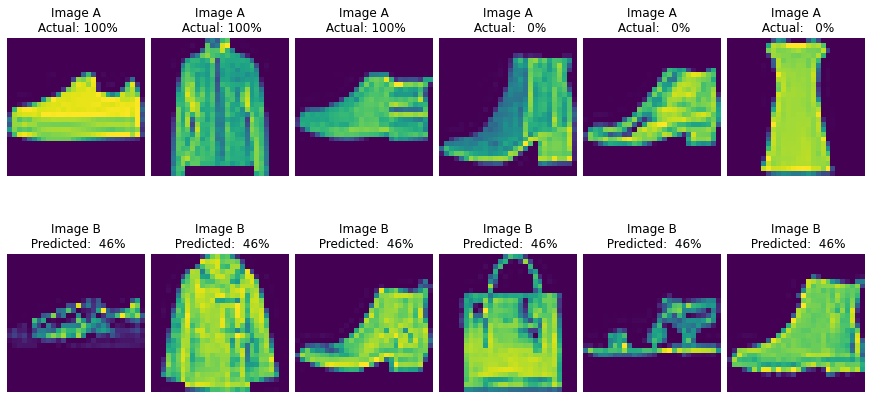

In [15]:
#untrained model
_ = show_model_output()

In [16]:
def siam_gen(in_groups, batch_size=32):
    while True:
        pv_a, pv_b, pv_sim = gen_random_batch(train_groups, batch_size//2)
        yield [pv_a, pv_b], pv_sim

valid_a, valid_b, valid_sim = gen_random_batch(test_groups, 1024)
loss_history = similarity_model.fit(
    siam_gen(train_groups),
    steps_per_epoch=500,
    validation_data=([valid_a, valid_b], valid_sim),
    epochs=10,
    verbose=True
)

Epoch 1/10
500/500 [==============================] - 114s 228ms/step - loss: 0.5870 - accuracy: 0.6879 - mae: 0.4122 - val_loss: 0.5308 - val_accuracy: 0.7134 - val_mae: 0.3706
Epoch 2/10
500/500 [==============================] - 114s 229ms/step - loss: 0.4969 - accuracy: 0.7328 - mae: 0.3466 - val_loss: 0.5136 - val_accuracy: 0.7183 - val_mae: 0.3498
Epoch 3/10
500/500 [==============================] - 117s 233ms/step - loss: 0.4956 - accuracy: 0.7268 - mae: 0.3426 - val_loss: 0.5122 - val_accuracy: 0.7192 - val_mae: 0.3534
Epoch 4/10
500/500 [==============================] - 115s 230ms/step - loss: 0.5035 - accuracy: 0.7241 - mae: 0.3433 - val_loss: 0.5816 - val_accuracy: 0.7119 - val_mae: 0.3582
Epoch 5/10
500/500 [==============================] - 117s 234ms/step - loss: 0.5047 - accuracy: 0.7467 - mae: 0.3390 - val_loss: 0.5092 - val_accuracy: 0.7402 - val_mae: 0.3471
Epoch 6/10
500/500 [==============================] - 116s 233ms/step - loss: 0.4820 - accuracy: 0.7588 - mae:

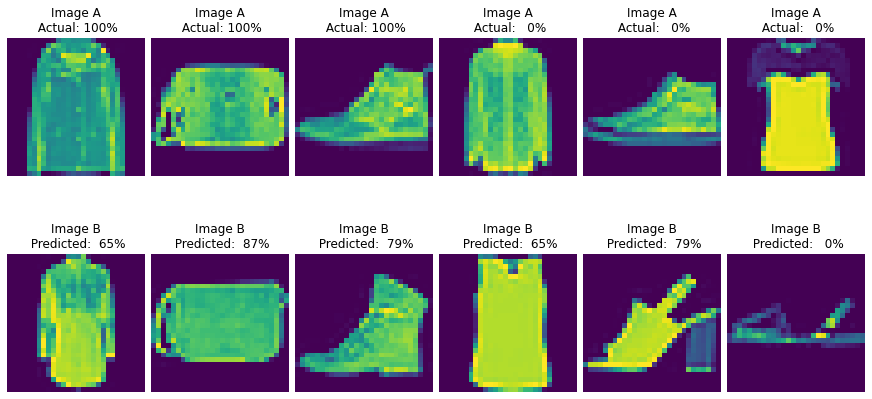

In [17]:
#trained model
_ = show_model_output()

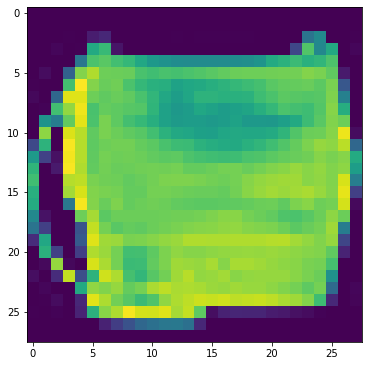

In [18]:
plt.rcParams["figure.figsize"] = (5,5)
image = x_train[47]
plt.imshow(image[:, :, 0])

In [19]:
t_shirt_vec = np.stack([train_groups[0][0]]*x_test.shape[0], 0)
t_shirt_score = similarity_model.predict([t_shirt_vec, x_test], verbose=True, batch_size=128)
ankle_boot_vec = np.stack([train_groups[-1][0]]*x_test.shape[0], 0)
ankle_boot_score = similarity_model.predict([ankle_boot_vec, x_test], verbose=True, batch_size=128)

79/79 [==============================] - 5s 58ms/step


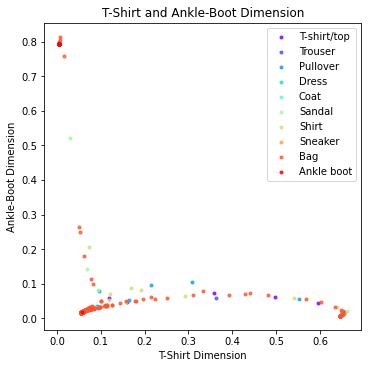

In [20]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress', 'Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        t_shirt_score[np.where(y_test == c_group), 0],
        ankle_boot_score[np.where(y_test == c_group), 0],
        marker='.',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('T-Shirt Dimension')
plt.ylabel('Ankle-Boot Dimension')
plt.title('T-Shirt and Ankle-Boot Dimension')
plt.legend(loc='best')
plt.show(block=False)

In [21]:
x_test_features = feature_model.predict(
    x_test,
    verbose=True,
    batch_size=128
)

79/79 [==============================] - 3s 33ms/step


In [22]:
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test_features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.006s...


C:\Users\Orest\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\Orest\anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

[t-SNE] Computed neighbors for 10000 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 0.741s


C:\Users\Orest\anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\Orest\anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] Iteration 50: error = 70.7706833, gradient norm = 0.0400367 (50 iterations in 2.905s)
[t-SNE] Iteration 100: error = 61.5474358, gradient norm = 0.0048249 (50 iterations in 2.890s)
[t-SNE] Iteration 150: error = 58.3171539, gradient norm = 0.0033697 (50 iterations in 2.723s)
[t-SNE] Iteration 200: error = 55.7547836, gradient norm = 0.0032617 (50 iterations in 2.616s)
[t-SNE] Iteration 250: error = 54.7549210, gradient norm = 0.0019301 (50 iterations in 2.569s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.754921


C:\Users\Orest\anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\Orest\anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] Iteration 300: error = 1.4494522, gradient norm = 0.0011357 (50 iterations in 2.525s)
[t-SNE] Iteration 350: error = 1.0152158, gradient norm = 0.0005333 (50 iterations in 2.600s)
[t-SNE] Iteration 400: error = 0.8100482, gradient norm = 0.0003087 (50 iterations in 2.573s)
[t-SNE] Iteration 450: error = 0.6997524, gradient norm = 0.0002040 (50 iterations in 2.708s)
[t-SNE] Iteration 500: error = 0.6338184, gradient norm = 0.0001469 (50 iterations in 2.635s)
[t-SNE] KL divergence after 500 iterations: 0.633818


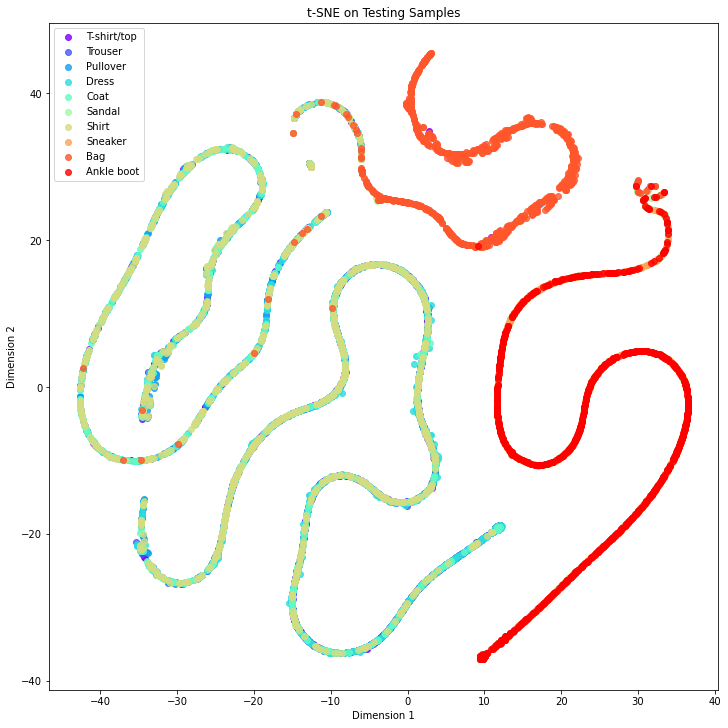

In [23]:
obj_categories = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=(10, 10))

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        marker='o',
        color=c_color,
        linewidth=1,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.show(block=False)